This file is part of https://github.com/diehlpk/reusommer21.

Copyright (c) 2021 Patrick Diehl

This program is free software: you can redistribute it and/or modify  
it under the terms of the GNU General Public License as published by  
the Free Software Foundation, version 3.

This program is distributed in the hope that it will be useful, but 
WITHOUT ANY WARRANTY; without even the implied warranty of 
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU 
General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. 
If not, see <http://www.gnu.org/licenses/>.

In [1]:
from sympy import Symbol, simplify, lambdify
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import operator
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import FormatStrFormatter

In [2]:
def interpolate_lagrange(x, x_values, y_values):
    """
    x : value at which to evaluate y, should be between min and max x_values
    x_values: list or numpy array containing values of x
    y_values: list or numpy array contaning values of y
    """
    def _basis(j):
        p = [(x - x_values[m])/(x_values[j] - x_values[m]) for m in range(k) if m != j]
        return reduce(operator.mul, p)
    assert len(x_values) != 0 and (len(x_values) == len(y_values)), 'x and y cannot be empty and must have the same length'
    k = len(x_values)
    basis = []
    for j in range(k):
        basis.append(_basis(j))
    #return sum(_basis(j)*y_values[j] for j in range(k)) 
    return basis

In [3]:
example = "Quartic"
save_results = False
g = -1
con = []
has_condition = True

In [4]:
#############################################################################
# Solve the system
#############################################################################

def solve(M,f):
    return np.linalg.solve(M,f)

In [5]:
#############################################################################
# Loading
#############################################################################

def f(x):
    
    global g 

    if example == "Cubic":
        g = 3/27*3*3
        return -6/27*x
    elif example == "Quartic":
        g = 4/81 * 3 * 3 * 3
        return -12/81 * x*x
    elif example == "Quadratic":
        g = 6/9
        return -2/9
    elif example == "Linear":
        g = 1/3
        return 0
    elif example == "Linear-cubic":
        g = 31./4.
        if x < 1.5:
            return 0 
        else:
            return 9-6*x
    else:
        print("Error: Either provide Quadratic, Quartic, or Cubic")
        sys.exit()

def forceFull(n,x):
    
    force = np.zeros(n)
   
    for i in range(1,n-1):
        force[i] = f(x[i]) 
    
    force[n-1] = g 
    
    return force

def forceCoupling(n,x):
    
    dim = n
    
    force = np.zeros(dim)
   
    for i in range(1,dim-1):
        force[i] = f(x[i]) / exactSolution(x[dim-1])
    
    force[dim-1] = g / exactSolution(x[dim-1])
    
    return force

In [6]:
#############################################################################
# Exact solution 
#############################################################################

def exactSolution(x):
    
    if example == "Cubic":
        return 1/27 * x * x * x
    elif example == "Quartic":
        return x * x * x * x / 81
    elif example == "Quadratic":
        return 1/9 * x * x
    elif example == "Linear":
        return x/3
    elif example == "Linear-cubic":
        return np.where(x < 1.5, x, x + (x-1.5) * (x-1.5) * (x-1.5) )
    else:
        print("Error: Either provide Linear, Quadratic, Quartic, or Cubic")
        sys.exit()

In [7]:
#############################################################################
# Assemble the stiffness matrix for the finite difference model (FD)
#############################################################################

def FDM(n,h):

    M = np.zeros([n,n])

    M[0][0] = 1

    for i in range(1,n-1):
        M[i][i-1] = -2
        M[i][i] = 4
        M[i][i+1] = -2

    M[n-1][n-1] = 11*h / 3
    M[n-1][n-2] = -18*h / 3
    M[n-1][n-3] = 9 * h / 3
    M[n-1][n-4] = -2 * h / 3

    M *= 1./(2.*h*h)

    return M

In [8]:
#############################################################################
# Assemble the stiffness matrix for the coupling of FDM - VHM - FDM
#############################################################################

def CouplingMDCM(n,h,nFD,hFD,xAll):

    fVHM = 1./(8.*h*h)
    fFDM = 1./(2.*hFD*hFD)
    
    dim = 2*nFD + n + 3
    
    M = np.zeros([dim,dim])
    
    M[0][0] = 1 

    for i in range(1,nFD-1):
        M[i][i-1] = -2 * fFDM
        M[i][i] = 4 * fFDM
        M[i][i+1] = -2 * fFDM 
    
    # Interpolate the last FD node
    weights = interpolate_lagrange(xAll[nFD-1], [xAll[nFD],xAll[nFD+1],xAll[nFD+2],xAll[nFD+3]], ["u1","u2","u3","u4"])
    M[nFD-1][nFD-1] = -1 # FM node at 1 
    M[nFD-1][nFD] = weights[0]
    M[nFD-1][nFD+1] = weights[1]
    M[nFD-1][nFD+2] = weights[2]
    M[nFD-1][nFD+3] = weights[3]
                      
    # Interpolate the first PD node
    weights = interpolate_lagrange(xAll[nFD], [xAll[nFD-4],xAll[nFD-3],xAll[nFD-2],xAll[nFD-1]], ["u1","u2","u3","u4"])
    M[nFD][nFD] = -1
    M[nFD][nFD-1] = weights[3] 
    M[nFD][nFD-2] = weights[2]
    M[nFD][nFD-3] = weights[1]
    M[nFD][nFD-4] = weights[0]
    
    # Interpolate the second PD node
    weights = interpolate_lagrange(xAll[nFD+1], [xAll[nFD-4],xAll[nFD-3],xAll[nFD-2],xAll[nFD-1]], ["u1","u2","u3","u4"])
    M[nFD+1][nFD+1] = -1
    M[nFD+1][nFD-1] = weights[3] 
    M[nFD+1][nFD-2] = weights[2]
    M[nFD+1][nFD-3] = weights[1]
    M[nFD+1][nFD-4] = weights[0]
         
    mid = nFD+n+1
    
    for i in range(nFD+2,mid):
        M[i][i-2] = -1. * fVHM
        M[i][i-1] = -4. * fVHM
        M[i][i] = 10. * fVHM
        M[i][i+1] =  -4. * fVHM
        M[i][i+2] = -1. * fVHM
    
    # Interpolate the first PD node
    weights = interpolate_lagrange(xAll[mid], [xAll[mid+2],xAll[mid+3],xAll[mid+4],xAll[mid+5]], ["u1","u2","u3","u4"])
    M[mid][mid] = -1 
    M[mid][mid+2] = weights[0]
    M[mid][mid+3] = weights[1]
    M[mid][mid+4] = weights[2]
    M[mid][mid+5] = weights[3]

    # Interpolate the second PD node
    weights = interpolate_lagrange(xAll[mid+1], [xAll[mid+2],xAll[mid+3],xAll[mid+4],xAll[mid+5]], ["u1","u2","u3","u4"])
    M[mid+1][mid+1] = -1
    M[mid+1][mid+2] = weights[0]
    M[mid+1][mid+3] = weights[1]
    M[mid+1][mid+4] = weights[2]
    M[mid+1][mid+5] = weights[3]
    
    # Same end node and start node
    weights = interpolate_lagrange(xAll[mid+2], [xAll[mid-2],xAll[mid-1],xAll[mid],xAll[mid+1]], ["u1","u2","u3","u4"])
    M[mid+2][mid+2] = -1
    M[mid+2][mid-2] = weights[0]
    M[mid+2][mid-1] = weights[1]
    M[mid+2][mid] = weights[2]
    M[mid+2][mid+1] = weights[3]
    
    for i in range(mid+3,dim-1):
        M[i][i-1] = -2 * fFDM
        M[i][i] = 4 * fFDM
        M[i][i+1] = -2 * fFDM

    
    M[dim-1][dim-1] = 11 *  hFD * fFDM / 3
    M[dim-1][dim-2] =  -18 * hFD * fFDM  / 3
    M[dim-1][dim-3] = 9 * hFD * fFDM / 3
    M[dim-1][dim-4] = -2 * hFD * fFDM / 3
    
    if has_condition:
        con.append(np.linalg.cond(M))
        
    return M

In [9]:
def compute(amount):


    hFD = 1./ amount
    h = hFD / 5
    nFD = int(1 / hFD)+1
    n = int(1 / h)+1
    
    x1 = np.linspace(0,1,nFD)  
    x2 = np.linspace(1-1.5*h,2+1.5*h,n+3)
    x3 = np.linspace(2*1,3*1,nFD)
    xFull = np.linspace(0,3*1,3*nFD-2)
    xAll = np.concatenate([x1,x2,x3])

    
    forceFD = forceFull(len(xFull),xFull)
    MFD = FDM(len(xFull),hFD)
    
    uFDM = solve(MFD,forceFD) 

    forceCoupled = forceCoupling(len(xAll),xAll)
    

    forceCoupled[nFD-1] = 0
    forceCoupled[nFD] = 0
    forceCoupled[nFD+1] = 0

    forceCoupled[nFD+n+1] = 0
    forceCoupled[nFD+n+2] = 0
    forceCoupled[nFD+n+3] = 0    

    MCoupling = CouplingMDCM(n,h,nFD,hFD,xAll)
    np.savetxt("m.csv", MCoupling, delimiter=",")
    uCoupled = solve(MCoupling,forceCoupled) 
        
    return xAll, xFull, uCoupled, uFDM , nFD, n
    
    

In [10]:
xAll = []
xFull = []
uCoupled = []
uFDM = []
nFD = []
n = []
for i in range(5, 9):
    
    res = compute(i)
    xAll.append(res[0])
    xFull.append(res[1])
    uCoupled.append(res[2])
    uFDM.append(res[3])
    nFD.append(res[4])
    n.append(res[5])

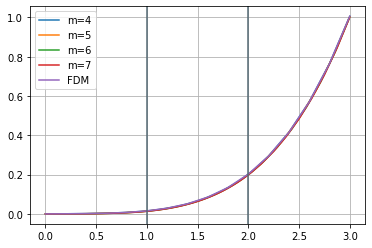

In [11]:
xSlice = []
uSlice = []

for i in range(0, len(xAll)):
    xSlice.append(np.concatenate([xAll[i][0:nFD[i]-1],xAll[i][nFD[i]:nFD[i]+2],[xAll[i][nFD[i]-1]],xAll[i][nFD[i]+2:nFD[i]+n[i]+1],[xAll[i][nFD[i]+n[i]+3]],xAll[i][nFD[i]+n[i]+1:nFD[i]+n[i]+3],xAll[i][nFD[i]+n[i]+4:]]))
    uSlice.append(np.concatenate([uCoupled[i][0:nFD[i]-1],uCoupled[i][nFD[i]:nFD[i]+2],[uCoupled[i][nFD[i]-1]],uCoupled[i][nFD[i]+2:nFD[i]+n[i]+1],[uCoupled[i][nFD[i]+n[i]+3]],uCoupled[i][nFD[i]+n[i]+1:nFD[i]+n[i]+3],uCoupled[i][nFD[i]+n[i]+4:]]))
    plt.plot(xSlice[i],uSlice[i],label="m="+str(i+4))
    
    
plt.plot(xFull[0],uFDM[0],label="FDM")
plt.grid()
plt.legend()
plt.axvline(x=1,c="#536872")
plt.axvline(x=2,c="#536872")

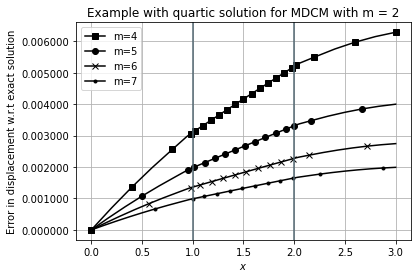

In [14]:
plt.clf()
markers = ['s','o','x','.']
level = [2,3,4,5]

for i in range(0, len(xAll)):
    plt.plot(xSlice[i],uSlice[i]-exactSolution(xSlice[i]),color="black",marker=markers[i],markevery=level[i],label="m="+str(i+4))
    
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%0.6f')) 
plt.xlabel(r"$x$")
plt.ylabel(r"Error in displacement w.r.t exact solution")
plt.title(r"Example with " + str(example).lower() + " solution for MDCM with m = 2")
plt.grid()
plt.axvline(x=1,c="#536872")
plt.axvline(x=2,c="#536872")
plt.legend()
plt.savefig("MDCM-adaptive-endpoint-non-matching-cubic-"+str(example).lower()+".pdf")

In [13]:
if has_condition :
    np.savetxt("con_mdcm_n-cubic-matching.csv", con, delimiter=",")